In [154]:
#from fastai import *
from fastbook import *
from fastai.tabular.all import *
from fastai import *

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import graphviz
import regex as re

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [27]:
# Load datasets
print('Load training GEDI shots')
gedi_train = pd.read_csv(f"/maps/fire-regen/data/rf/gedi_train.csv", index_col=0)

print('Load validation GEDI shots')
gedi_valid = pd.read_csv(f"/maps/fire-regen/data/rf/gedi_validation.csv", index_col=0)

Load training GEDI shots
Load validation GEDI shots


In [105]:
columns_to_keep = ['agbd', 'beam_type', 'sensitivity', 'pft_class', 'gedi_year', 'gedi_month', 'burn_severity_median',
'burn_year_median', 'burn_counts_median', 'elevation', 'slope', 'aspect', 'soil', 'land_cover', 'nbr', 'ndvi',
'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'time_since_burn']

In [106]:
gedi_train.beam_type.unique()

array(['full', 'coverage'], dtype=object)

In [212]:
print(gedi_train.shape[0])
#print(gedi_train[gedi_train.sensitivity > 0.95].shape[0])
#print(gedi_train[gedi_train.beam_type == "full"].shape[0])
print(gedi_train[(gedi_train.slope > 6) & (gedi_train.elevation > 1500)].shape[0])
print(gedi_train[gedi_train.ndvi < 0.2].shape[0])

6421929
2138431
3560043


In [237]:
gedi_train[(gedi_train.slope > 100) & (gedi_train.elevation > 1500) &(gedi_train.pft_class==1)].agbd.quantile(0.75)

nan

In [228]:
gedi_train[(gedi_train.slope <= 6) | (gedi_train.elevation < 1500)&(gedi_train.pft_class==1)].agbd.quantile(0.75)

95.22056579589844

In [107]:
gedi_data_train= gedi_train[columns_to_keep]
gedi_data_valid= gedi_valid[columns_to_keep]

In [109]:
beam_types = 'full', 'coverage'
gedi_data_train['beam_type'] = gedi_data_train['beam_type'].astype('category')
gedi_data_train['beam_type'].cat.set_categories(beam_types, ordered=False, inplace=True)

/tmp/ipykernel_4137761/4003133587.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.


In [110]:
gedi_data_valid['beam_type'] = gedi_data_valid['beam_type'].astype('category')
gedi_data_valid['beam_type'].cat.set_categories(beam_types, ordered=False, inplace=True)

/tmp/ipykernel_4137761/2408582660.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.


In [30]:
gedi_data_valid.dtypes

longitude                float64
latitude                 float64
agbd                     float64
beam_type               category
sensitivity              float64
pft_class                  int64
gedi_year                  int64
gedi_month                 int64
burn_severity_median     float64
burn_year_median         float64
burn_counts_median       float64
elevation                  int64
slope                      int64
aspect                     int64
soil                       int64
land_cover                 int64
nbr                      float64
ndvi                     float64
SR_B1                    float64
SR_B2                    float64
SR_B3                    float64
SR_B4                    float64
SR_B5                    float64
SR_B6                    float64
SR_B7                    float64
dtype: object

### Let's use RMSLE error

See https://datascience.stackexchange.com/questions/63514/what-is-the-difference-between-an-rmse-and-rmsle-logarithmic-error#:~:text=RMSLE%20has%20the%20meaning%20of,around%201%20to%20around%20100. for more details. But, it seems to me, we want a relative error rather than absolute.

In [33]:
dep_var = 'agbd'

In [111]:
# Remove any rows where agbd == 0
gedi_data_train = gedi_data_train[gedi_data_train.agbd != 0]
gedi_data_valid= gedi_data_valid[gedi_data_valid.agbd != 0]

(0.0, 100000.0)

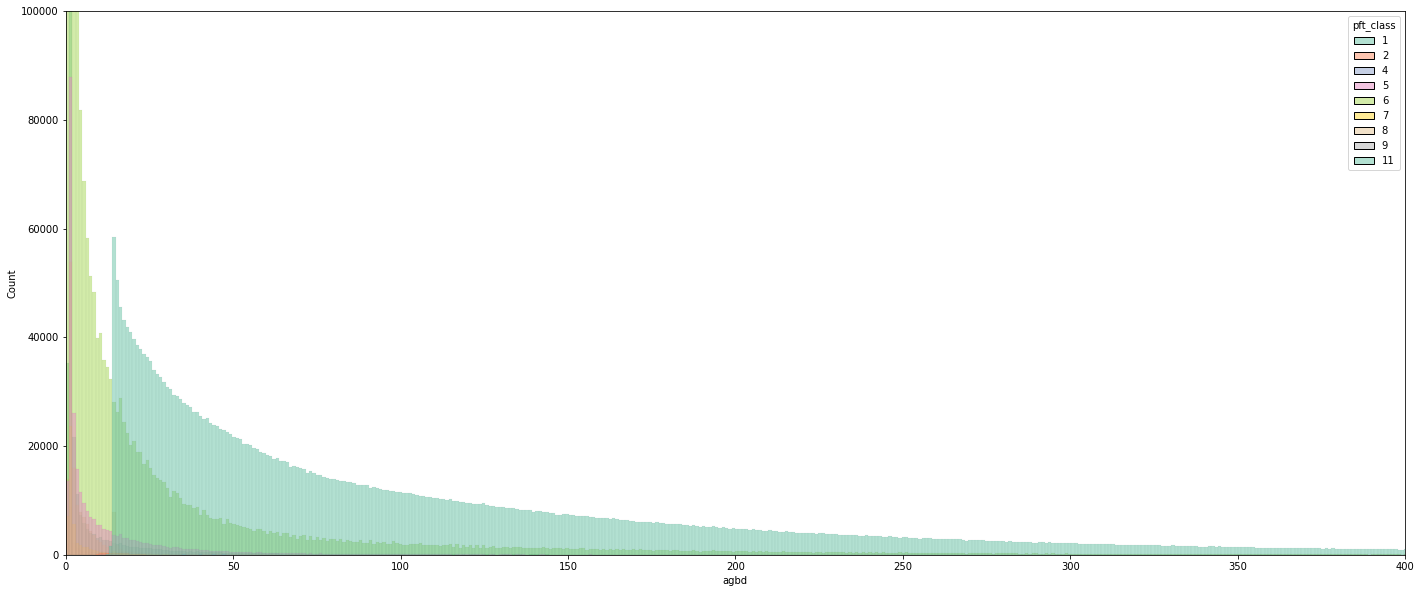

In [73]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(24, 10))
sns.histplot(gedi_data_train, x='agbd', ax=ax, hue='pft_class', palette='Set2')
ax.set_xlim((0, 400))
ax.set_ylim((0, 100000))

In [74]:
gedi_data_train['log_agbd'] = np.log(gedi_data_train.agbd)

<AxesSubplot: xlabel='log_agbd', ylabel='Count'>

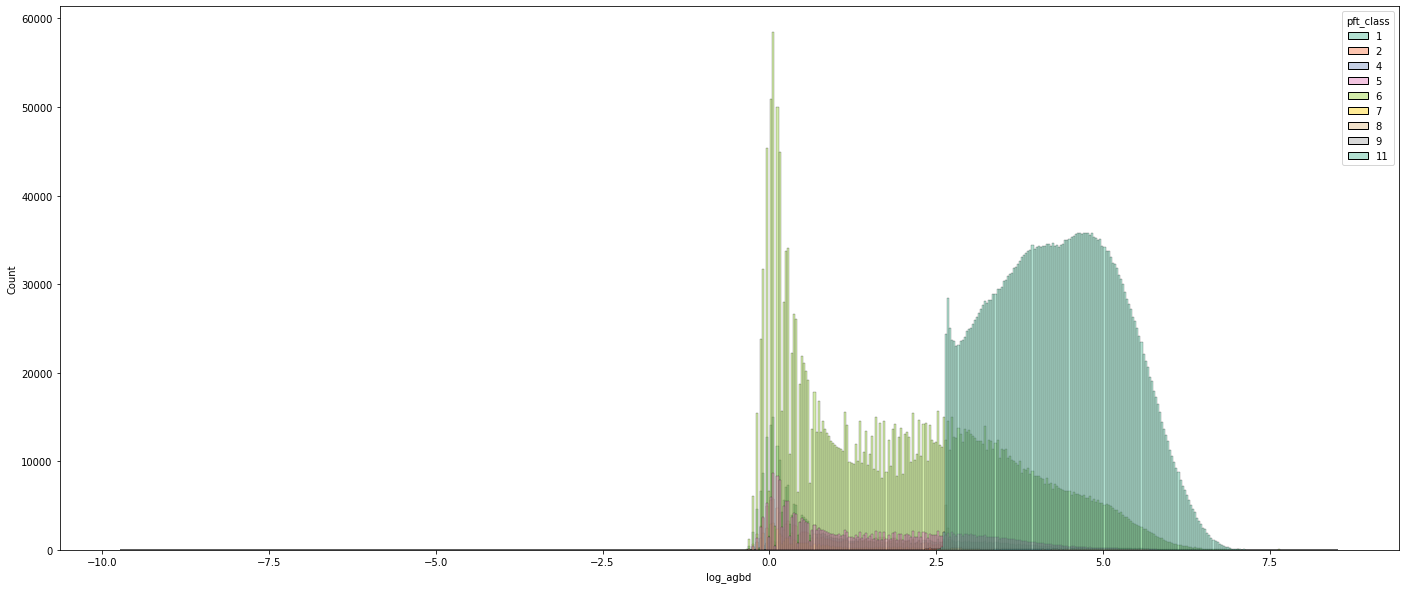

In [75]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(24, 10))
sns.histplot(gedi_data_train, x='log_agbd', ax=ax, hue='pft_class', palette='Set2')

<AxesSubplot: xlabel='log_agbd', ylabel='Count'>

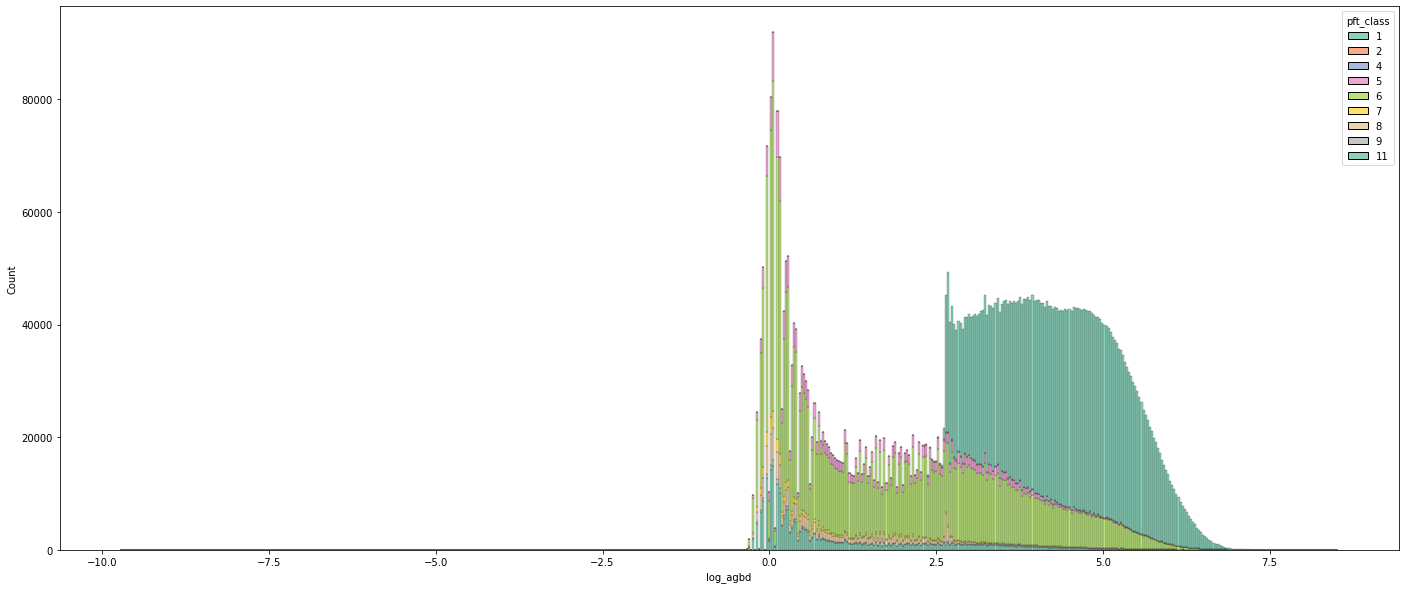

In [76]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(24, 10))
sns.histplot(gedi_data_train, x='log_agbd', ax=ax, hue='pft_class', palette='Set2', multiple="stack")

<AxesSubplot: xlabel='log_agbd', ylabel='Count'>

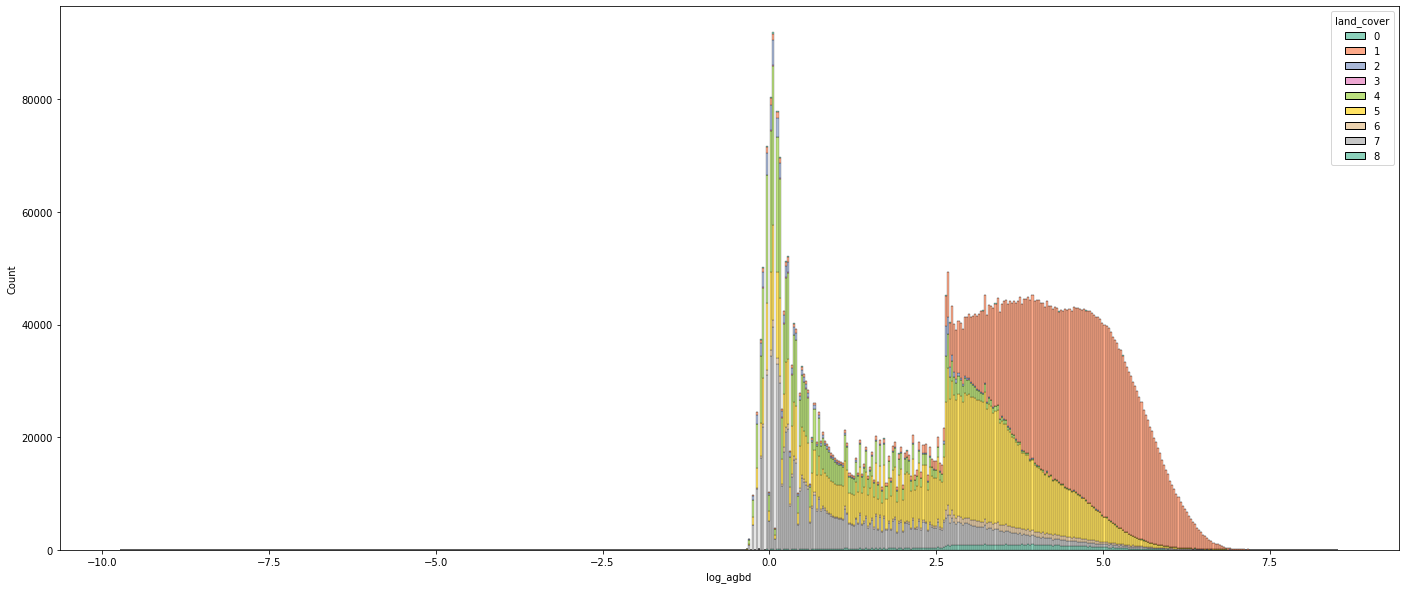

In [77]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(24, 10))
sns.histplot(gedi_data_train, x='log_agbd', ax=ax, hue='land_cover', palette='Set2', multiple="stack")

<AxesSubplot: xlabel='log_agbd', ylabel='Count'>

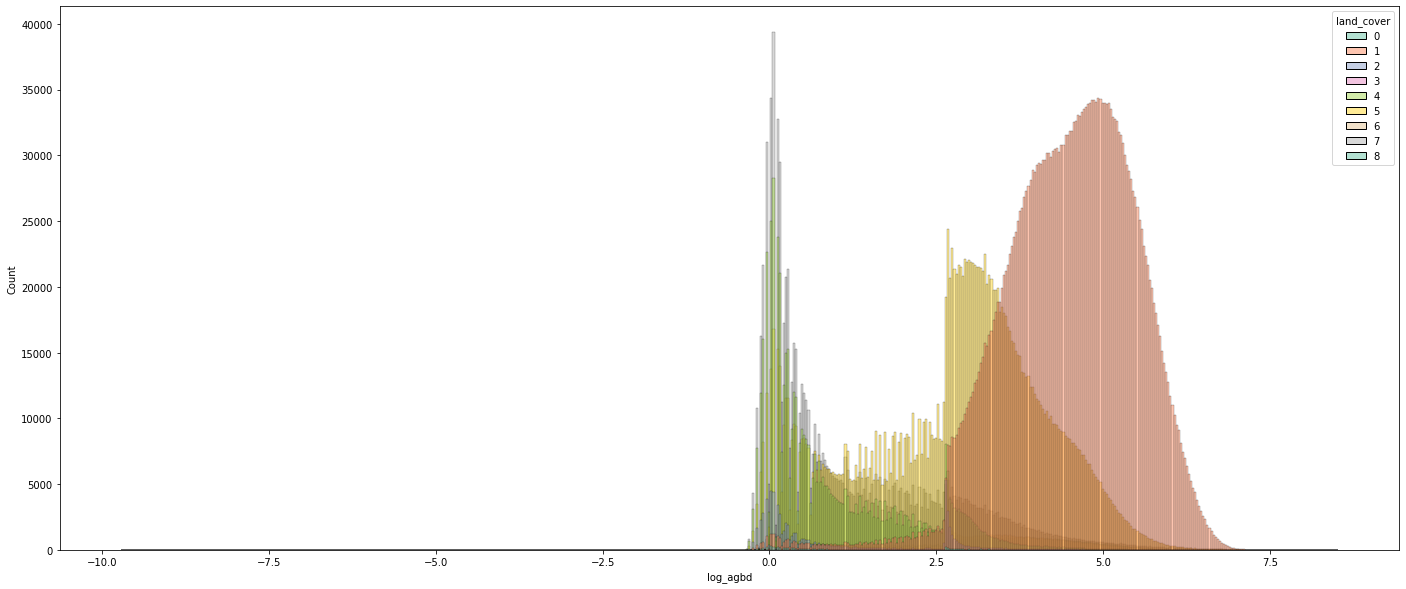

In [79]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(24, 10))
sns.histplot(gedi_data_train, x='log_agbd', ax=ax, hue='land_cover', palette='Set2')

<AxesSubplot: xlabel='log_agbd', ylabel='Count'>

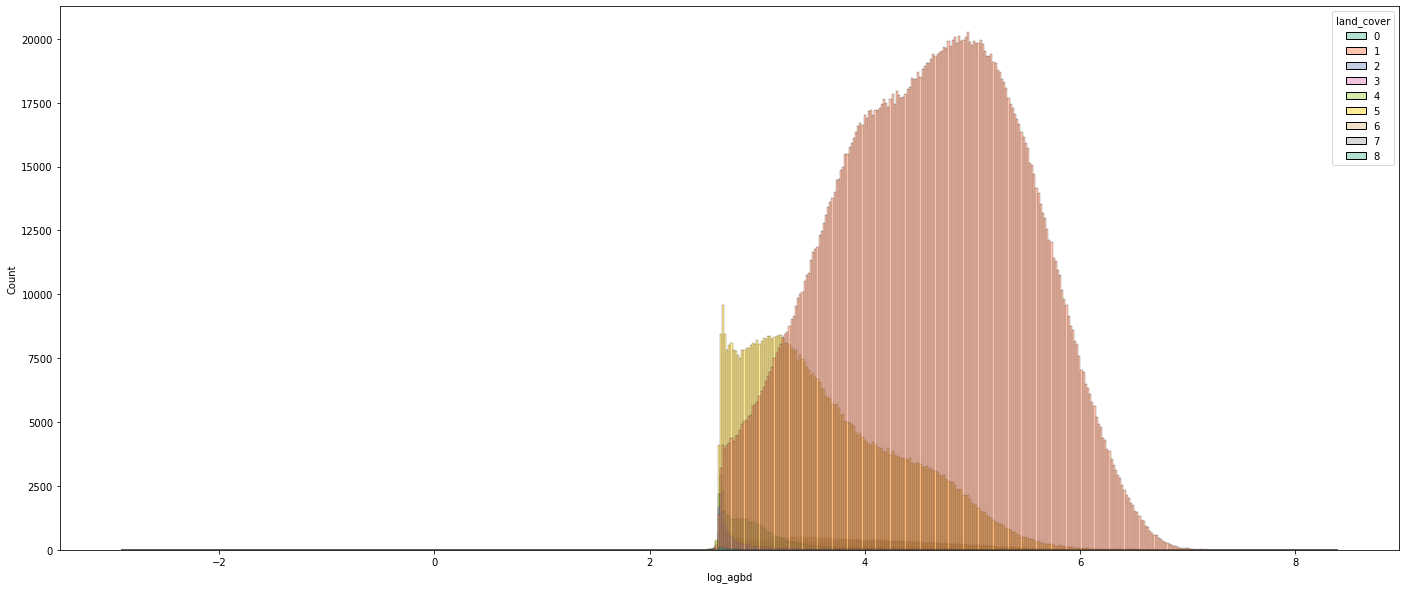

In [80]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(24, 10))
sns.histplot(gedi_data_train[gedi_data_train.pft_class==1], x='log_agbd', ax=ax, hue='land_cover', palette='Set2')

<AxesSubplot: xlabel='log_agbd', ylabel='Count'>

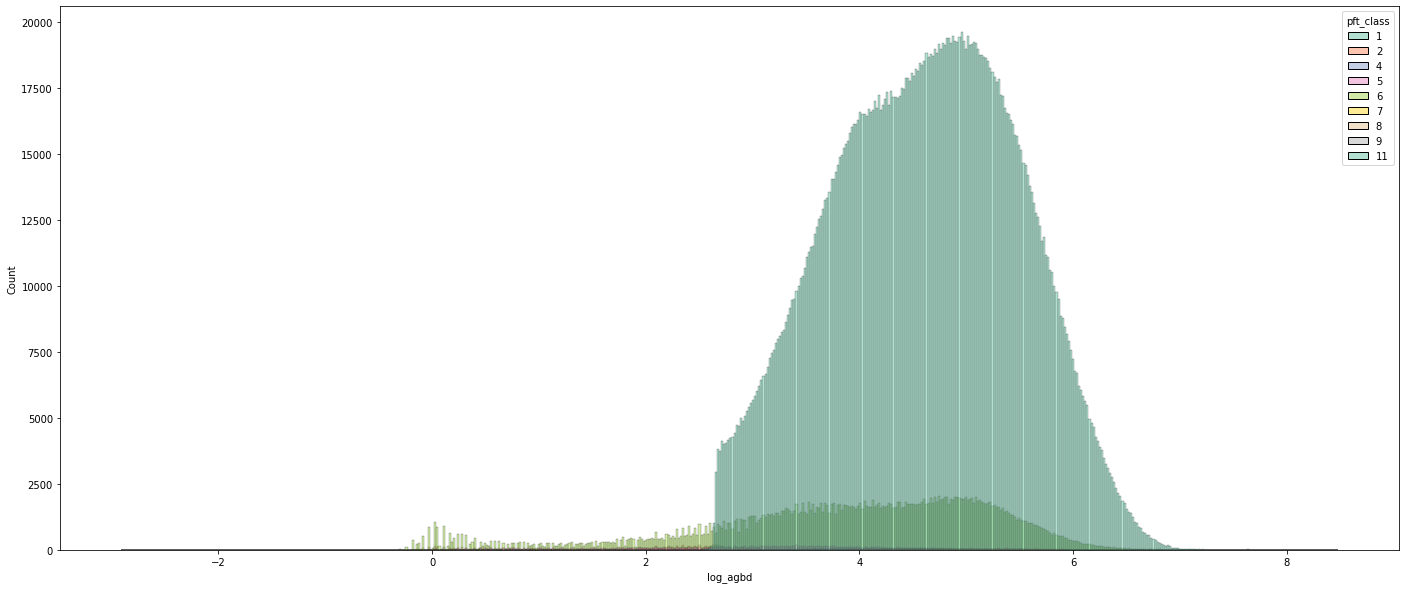

In [81]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(24, 10))
sns.histplot(gedi_data_train[gedi_data_train.land_cover==1], x='log_agbd', ax=ax, hue='pft_class', palette='Set2')

In [85]:
gedi_data_train = gedi_data_train.drop(columns='log_agbd')

In [86]:
gedi_data_train.columns

Index(['longitude', 'latitude', 'agbd', 'beam_type', 'sensitivity',
       'pft_class', 'gedi_year', 'gedi_month', 'burn_severity_median',
       'burn_year_median', 'burn_counts_median', 'elevation', 'slope',
       'aspect', 'soil', 'land_cover', 'nbr', 'ndvi', 'SR_B1', 'SR_B2',
       'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'time_since_burn'],
      dtype='object')

In [112]:
# Skip for now as it's hard to me to evaluate RMSLE meaning
gedi_data_train[dep_var] = np.log(gedi_data_train[dep_var])
gedi_data_valid[dep_var] = np.log(gedi_data_valid[dep_var])

In [92]:
procs = [Categorify, FillMissing]

In [113]:
cont, cat = cont_cat_split(gedi_data_train, 1, dep_var=dep_var)

In [114]:
train_data = TabularPandas(gedi_data_train, procs, cat, cont, y_names=dep_var)
valid_data = TabularPandas(gedi_data_valid, procs, cat, cont, y_names=dep_var)

In [38]:
save_pickle(f"/maps/fire-regen/data/rf/train_raw.pkl", train_data)
save_pickle(f"/maps/fire-regen/data/rf/valid_raw.pkl", valid_data)

In [3]:
train_data = load_pickle("/maps/fire-regen/data/rf/train_raw.pkl")
valid_data = load_pickle("/maps/fire-regen/data/rf/valid_raw.pkl")

### Creating the Decision Tree

In [115]:
xs, y = train_data.train.xs, train_data.train.y
valid_xs, valid_y = valid_data.train.xs, valid_data.train.y

In [40]:
m = DecisionTreeRegressor(max_leaf_nodes=50)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=50)

In [41]:
def print_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    gviz_input = re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s)
    print(gviz_input)

In [42]:
print_tree(m, xs, size=10, leaves_parallel=True, precision=2)

digraph Tree { size=10; ratio=0.6
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
graph [ranksep=equally, splines=polyline] ;
edge [fontname="helvetica"] ;
0 [label=<SR_B7 &le; 9703.79<br/>squared_error = 12032.75<br/>samples = 6421928<br/>value = 74.45>, fillcolor="#fbeade"] ;
1 [label=<SR_B7 &le; 8812.76<br/>squared_error = 21567.9<br/>samples = 1095168<br/>value = 210.0>, fillcolor="#f2c19d"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
5 [label=<SR_B4 &le; 7930.85<br/>squared_error = 27010.05<br/>samples = 370049<br/>value = 289.44>, fillcolor="#eda977"] ;
1 -> 5 ;
9 [label=<SR_B5 &le; 15085.03<br/>squared_error = 31229.9<br/>samples = 104241<br/>value = 348.03>, fillcolor="#e9975b"] ;
5 -> 9 ;
39 [label=<elevation &le; 1323.5<br/>squared_error = 34051.13<br/>samples = 66292<br/>value = 369.83>, fillcolor="#e89051"] ;
9 -> 39 ;
41 [label=<latitude &le; 39.64<br/>squared_error = 35405.07<br/>samples = 44519<br/>value = 394.4>, fill

In [8]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [43]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(77.649477, 76.811753)

In [15]:
gedi_data_train.agbd

NameError: name 'gedi_data_train' is not defined

In [17]:
np.exp(np.log(76))

76.0

In [18]:
np.exp(1)

2.718281828459045

In [19]:
np.exp(1.1)

3.0041660239464334

In [20]:
np.exp(0.1)

1.1051709180756477

### Random Forest

In [96]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [116]:
m = rf(xs, y)

In [117]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.748063, 0.769241)

In [47]:
r_mse(m.oob_prediction_, y)

71.470509

In [99]:
y.mean()

3.1519024

In [49]:
y.std()

109.69389

In [50]:
y

4146         1.564893
4147         6.131972
4148         1.748223
4149         1.061925
4150         8.075305
              ...    
6517882     40.898212
6517883     44.073734
6517884    140.756058
6517885     46.929424
6517886     32.186077
Name: agbd, Length: 6421928, dtype: float32

(0.0, 100000.0)

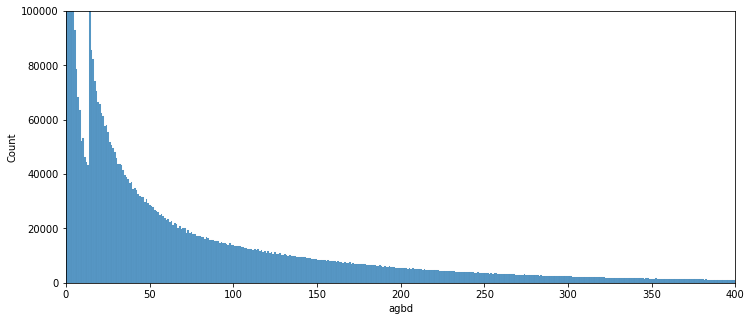

In [54]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.histplot(y, ax=ax)
ax.set_xlim((0, 400))
ax.set_ylim((0, 100000))

<AxesSubplot: xlabel='agbd', ylabel='Count'>

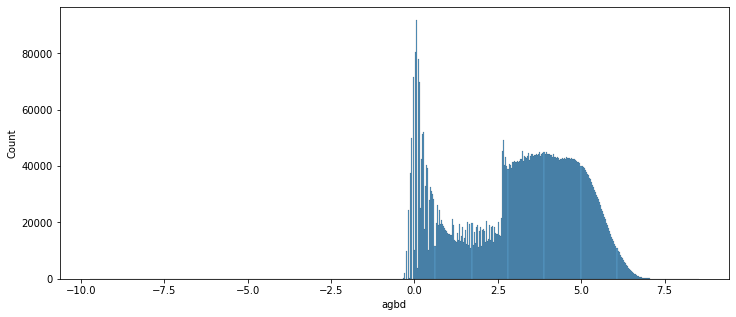

In [70]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.histplot(np.log(y), ax=ax)
#ax.set_xlim((0, 400))
#ax.set_ylim((0, 100000))

### Tree Variance for Prediction Confidence

In [55]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/sklearn/base.py:413: UserWar

In [56]:
preds.shape

(40, 1140176)

In [57]:
preds_std = preds.std(0)

In [58]:
preds_std[:5]

array([106.30411963,  66.29770012,  44.45391973,  59.96722767, 136.53046283])

In [59]:
np.argmax(preds_std)

529780

In [60]:
preds_std[529780]

703.708144315964

In [64]:
valid_xs.iloc[529780]

2362.5083

### Feature Importance

In [118]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [119]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
11,pft_class,0.315001
21,land_cover,0.149627
18,slope,0.139196
26,SR_B3,0.092474
30,SR_B7,0.044080
25,SR_B2,0.038738
27,SR_B4,0.038437
17,elevation,0.031333
29,SR_B6,0.029247
24,SR_B1,0.028528


In [68]:
np.exp(np.log(75)+0.75)

158.77500124595056

<AxesSubplot: ylabel='cols'>

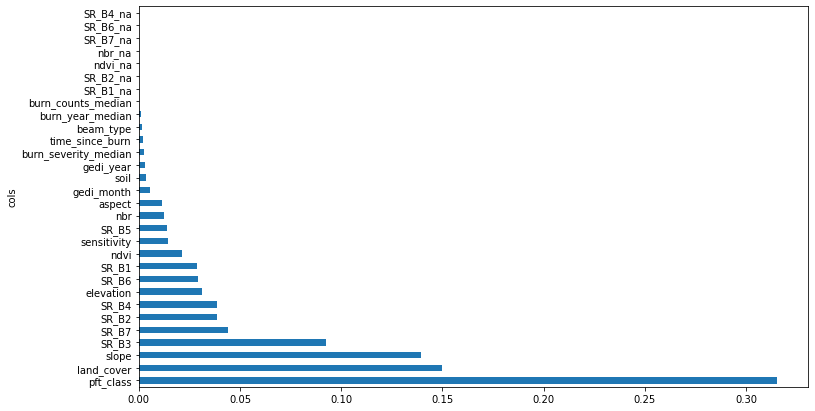

In [120]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30])

### Prune less important columns

In [130]:
to_keep = fi[fi.imp>0.001].cols
to_keep

11               pft_class
21              land_cover
18                   slope
26                   SR_B3
30                   SR_B7
25                   SR_B2
27                   SR_B4
17               elevation
29                   SR_B6
24                   SR_B1
23                    ndvi
10             sensitivity
28                   SR_B5
22                     nbr
19                  aspect
13              gedi_month
20                    soil
12               gedi_year
14    burn_severity_median
31         time_since_burn
0                beam_type
15        burn_year_median
Name: cols, dtype: object

In [131]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [132]:
m = rf(xs_imp, y)

In [133]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.747859, 0.769221)

<AxesSubplot: ylabel='cols'>

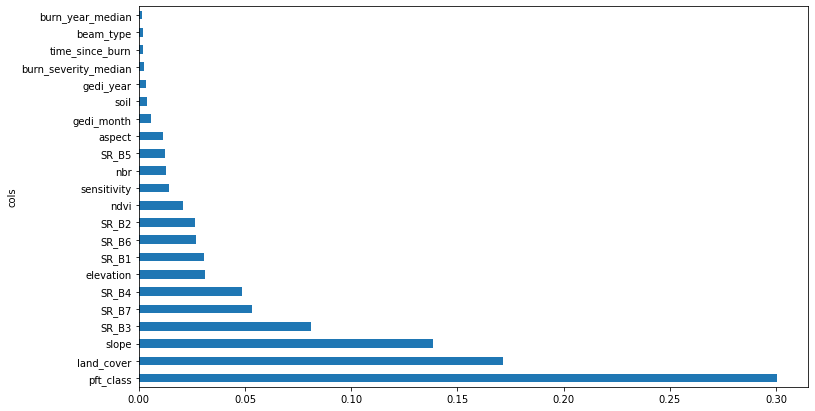

In [134]:
plot_fi(rf_feat_importance(m, xs_imp))

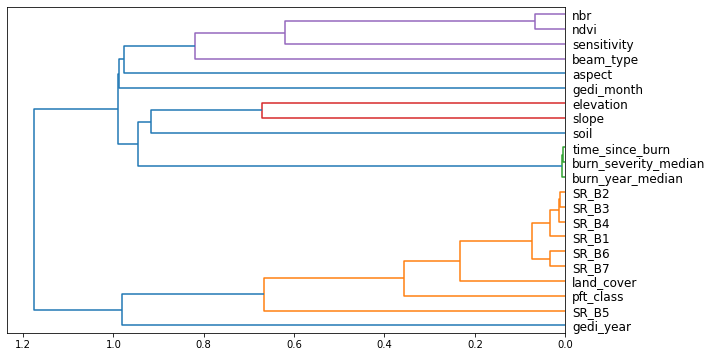

In [135]:
cluster_columns(xs_imp)

### Partial Dependence Plots

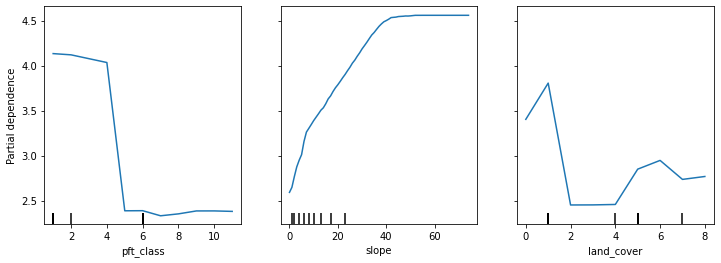

In [238]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
tree_disp = PartialDependenceDisplay.from_estimator(m, valid_xs_imp, ['pft_class','slope', 'land_cover'], ax=ax)
#plot_partial_dependence(m, valid_xs_final, ['pft_class','slope'],
#                        grid_resolution=20, ax=ax)

### Row-specific analysis

In [152]:
row = valid_xs_imp.iloc[:5]


In [155]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)


In [156]:
prediction[0], bias[0], contributions[0].sum()

(array([4.41882587]), 3.151055024397578, 1.267770847002839)

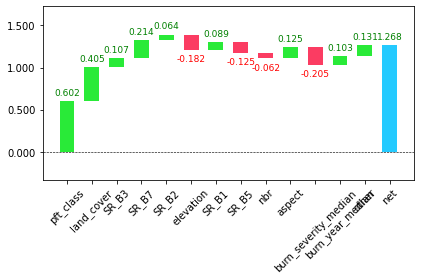

In [158]:
waterfall(valid_xs_imp.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

In [184]:
burned_rows = valid_xs_imp[(valid_xs_imp.burn_severity_median == 4)&(valid_xs_imp.time_since_burn > 25)].iloc[:5]

In [185]:
prediction,bias,contributions = treeinterpreter.predict(m, burned_rows.values)

<module 'matplotlib.pyplot' from '/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/matplotlib/pyplot.py'>

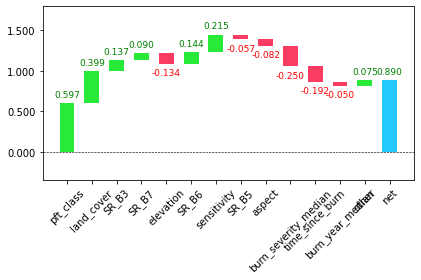

In [193]:
waterfall(valid_xs_imp.columns, contributions[4], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}')

In [194]:
contributions[4]

array([ 5.96729887e-01,  3.98997105e-01, -1.78098596e-02,  1.37216577e-01,  8.95566726e-02,  1.84082026e-02,  2.97640923e-02, -1.34082172e-01,  1.43569372e-01,  3.12021811e-02,  2.41348840e-02,
        2.14786374e-01, -5.74412209e-02,  3.98613508e-04, -8.20763217e-02, -1.79112393e-02,  4.46169049e-03,  3.79819822e-03, -2.50389184e-01, -1.92007143e-01, -1.72547766e-03, -4.99739132e-02])

In [190]:
valid_xs_imp.columns

Index(['pft_class', 'land_cover', 'slope', 'SR_B3', 'SR_B7', 'SR_B2', 'SR_B4',
       'elevation', 'SR_B6', 'SR_B1', 'ndvi', 'sensitivity', 'SR_B5', 'nbr',
       'aspect', 'gedi_month', 'soil', 'gedi_year', 'burn_severity_median',
       'time_since_burn', 'beam_type', 'burn_year_median'],
      dtype='object')

In [195]:
burned_rows.iloc[4]

pft_class                   1.000000
land_cover                  1.000000
slope                      12.000000
SR_B3                    8883.230469
SR_B7                    9561.307617
SR_B2                    8052.922852
SR_B4                    8717.077148
elevation                2100.000000
SR_B6                   11496.538086
SR_B1                    7778.384766
ndvi                        0.291392
sensitivity                 0.991468
SR_B5                   15886.307617
nbr                         0.248550
aspect                    284.000000
gedi_month                 11.000000
soil                        5.000000
gedi_year                2021.000000
burn_severity_median        4.000000
time_since_burn            30.000000
beam_type                   1.000000
burn_year_median         1991.000000
Name: 33272, dtype: float32

### Finding Out-of-Domain data

In [196]:
df_dom = pd.concat([xs_imp, valid_xs_imp])
is_valid = np.array([0]*len(xs_imp) + [1]*len(valid_xs_imp))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
7,elevation,0.107309
11,sensitivity,0.073525
14,aspect,0.072199
9,SR_B1,0.071497
10,ndvi,0.066356
13,nbr,0.065580


In [197]:
m = rf(xs_imp, y)
print('orig', m_rmse(m, valid_xs_imp, valid_y))

for c in ('elevation','sensitivity','aspect'):
    m = rf(xs_imp.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_imp.drop(c,axis=1), valid_y))

orig 0.769208
elevation 0.787804
sensitivity 0.776055
aspect 0.773855
